In [1]:
!pip install gymnasium
#!pip install pybullet
#!pip install robot_descriptions
#!pip install yourdfpy
#!pip install "pyglet<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.4 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import plotly.express as px
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as anm

Define the linearized dynamics of the system:

In [3]:
g = 9.8 #acceleration due to earth's gravity
lp = 0.5 #length of pole
mp = 0.1 #mass of pole
mk = 1 #mass of cart
mt = mp+mk

In [4]:
# state matrix
a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

Second, lets calculate the optimal controller:

In [5]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

And last, lets define a function, which we can call to actually calculate the input force F during runtime:

In [6]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

Now we can set up the simulation!

In [30]:
# get environment
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.observation_space.seed(1)     # seed for reproducibility
obs, _ = env.reset()
obs_ = [obs.tolist()]

out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (600, 400))

for i in range(200):
    img = env.render()
    out.write(img)

    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)

    # change magnitute of the applied force in CartPole
    abs_force = abs(float(np.clip(force, -2, 2)))
    env.force_mag = abs_force

    # apply action
    obs, reward, done, _, _ = env.step(action)
    obs_.append(obs.tolist())


    if done:
        print(f'Terminated after {i+1} iterations.')
        break

out.release()
env.close()

Plot the state variables

In [43]:
name = ['Position', 'Velocity', 'Vertical Angle', 'Angular Velocity']
fig = px.line()
for i in range(4):
  fig.add_scatter(x = np.linspace(1, len(obs_)+2, len(obs_)+1, dtype=np.int32), y = np.transpose(obs_)[i], name=name[i])
fig.show()


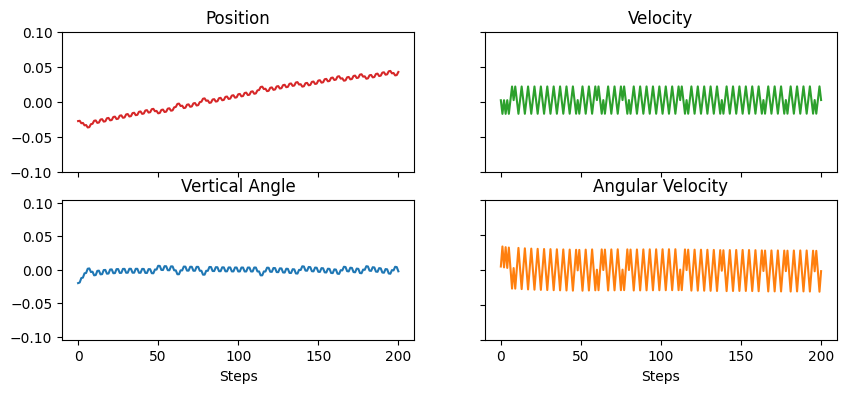

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,4))

colours = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']

for i in range(4):
  axs[int(i/2), i%2].plot(np.transpose(obs_)[i], colours[i])
  axs[int(i/2), i%2].set_title(name[i])

axs[0, 0].set_ylim([-0.1, 0.1])
axs[1, 0].set_ylim([-np.pi/30, np.pi/30])
axs[0, 1].set_ylim([-1., 1.])
axs[1, 1].set_ylim([-1., 1.])

#for ax in axs.flat:
axs[1,0].set(xlabel='Steps')
axs[1,1].set(xlabel='Steps')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.savefig('LQR_plot.png')